# Exemple simplifié - Ustilisation du développement binaire 

In [2]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from itertools import combinations
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize
from functools import reduce
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [ ]:
# mêmes exemples de valeurs 

q=2 #nombre de noeuds
P_i   = [4,2]         # la puissance maximale générée par chq noeud
c_i   = [3,8]       # coût par noeud
D_i   = [3,1]        # demande par noeud

In [4]:
# Génération des variables x(i,j) pour i correspond au ième noeud, j est le jème indicateur de g_i
x_vars = [(i, j) for i in range(q) for j in range(int(np.ceil(np.log2(P_i[i] + 1))))]
qubit_index = {f"x_{i}_{j}": idx for idx, (i,j) in enumerate(x_vars)}

def idx_x(i, j):
    return qubit_index[f"x_{i}_{j}"]

nqubit=len(x_vars)

print(nqubit)

5


In [ ]:
terms = []
lam =100# pénalité
D = np.sum(D_i)
nqubit = len(x_vars)  # nombre total de qubits
const = 0.0

# Précalcul des valeurs 2^j pour chaque qubit
powers = [2**j for (_, j) in x_vars]
T = sum(powers)  # somme totale de toutes les valeurs 2^j


for idx, ((i, j), pow_j) in enumerate(zip(x_vars, powers)):
    coeff_linear = (c_i[i] * pow_j - 2 * lam * D * pow_j + lam * (pow_j**2)) / 2
    
    # Construction du terme Pauli
    pauli_term = ['I'] * nqubit
    pauli_term[idx] = 'Z'
    terms.append((''.join(pauli_term), -coeff_linear))  # Inversion de signe
    
    # Mise à jour de la constante
    const += coeff_linear



for a, (i, j) in enumerate(x_vars):
    pow_j = powers[a]
    for b, (k, l) in enumerate(x_vars):
        if b <= a:
            continue
            
        pow_l = powers[b]
        # Coefficient unique pour toutes les paires
        coeff_quad = lam * pow_j * pow_l
        
        # Construction du terme Pauli
        pauli_term = ['I'] * nqubit
        pauli_term[a] = 'Z'
        pauli_term[b] = 'Z'
        terms.append((''.join(pauli_term), coeff_quad))
        
        # Mise à jour de la constante
        const += coeff_quad

# Ajout des termes manquants (d'après le développement mathématique)
const += lam * (D**2 - D * T + 0.25 * T**2)

# Ajout du terme constant global
terms.append(('I' * nqubit, const))

## Construction de l'hamiltonien de coût

In [7]:
H_c = SparsePauliOp.from_list(terms)

## Construction de l'hamultonien de mélange

In [8]:
from qiskit.quantum_info import SparsePauliOp

H_M = SparsePauliOp.from_list([
    ('I'*i + 'X' + 'I'*(nqubit-i-1), 1.0)
    for i in range(nqubit)
])

## Construction des opérateurs d'évolution temporelle

In [9]:
from qiskit.circuit.library import PauliEvolutionGate
def U_C(gamma, H):
    gate = PauliEvolutionGate(H, time=gamma)
    return gate.definition  

def U_M(beta, H):
    gate = PauliEvolutionGate(H, time=beta)
    return gate.definition

## Fonction de construction de l'Ansatz

In [10]:
from qiskit import QuantumCircuit

def build_qaoa_circuit(n, p, gammas, betas, cost_h, mixer_h):
    qc = QuantumCircuit(n)  
    qc.h(range(n))          
    
    for layer in range(p):
        qc.append(U_C(float(gammas[layer]), cost_h), range(n))
        qc.append(U_M(float(betas[layer]), mixer_h), range(n))
    
    return qc 

### On fait la mesure pour différentes profondeurs:

p=15

Paramètres optimaux : [-0.0095018   1.54512532  3.01001492 -0.3038819   1.65181917  1.3601134 ]
Espérance d'énergie minimale : -9330.149141038191


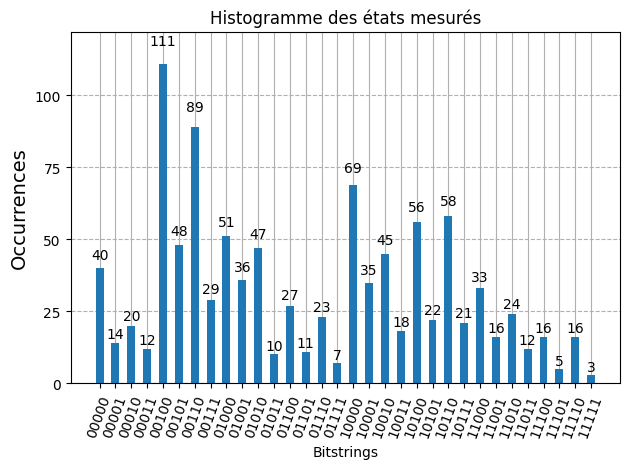

Top résultats QAOA:
00100 : 111 fois
00110 : 89 fois
10000 : 69 fois
10110 : 58 fois
10100 : 56 fois
Résultats de mesure : {'11010': 24, '00001': 14, '10000': 69, '01010': 47, '00010': 20, '10010': 45, '10100': 56, '00100': 111, '00011': 12, '00000': 40, '11110': 16, '01001': 36, '11000': 33, '00110': 89, '00111': 29, '01110': 23, '01011': 10, '00101': 48, '11001': 16, '10001': 35, '11100': 16, '11111': 3, '01111': 7, '10110': 58, '10011': 18, '01101': 11, '10111': 21, '01000': 51, '01100': 27, '10101': 22, '11011': 12, '11101': 5}
Temps d'exécution : 15.405552625656128 secondes


In [ ]:
%matplotlib inline
import time 
from collections import Counter
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator  
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize


p=15# la profondeur


backend = Aer.get_backend('aer_simulator')

def qaoa_expectation(params):
    gammas = params[:p]
    betas = params[p:]
    
    qc = build_qaoa_circuit(nqubit, p, gammas, betas, H_c, H_M)
    qc.save_statevector()
    
    qc_transpiled = transpile(qc, backend)
    result = backend.run(qc_transpiled).result()
    
    sv = result.data(0)['statevector']
    expval = sv.expectation_value(H_c)
    return np.real(expval)  

#On initialise les valeurs de betas et gammas aléatoirement
gammas = np.linspace(0, np.pi, p) 
betas = np.linspace(0, np.pi/2, p)
params = np.concatenate([gammas, betas]) # point de départ --> initialisation



start = time.time() # on veut trouver le temps d'exécution

#result = minimize(qaoa_expectation, params, method='L-BFGS-B') #mesure
result = minimize(qaoa_expectation, params, method='COBYLA')
print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", result.fun)

# Circuit avec les paramètres optimaux --> etat pi(beta, gamma)
cost_h=H_c
mixer_h=H_M

gammas=result.x[:p]
betas=result.x[p:]

qc3 = build_qaoa_circuit(nqubit,p, gammas,betas,cost_h,mixer_h)
qc3.measure_all()
qc_transpiled3 = transpile(qc3, AerSimulator())

job = AerSimulator().run(qc_transpiled3, shots=1024)
result_new = job.result()
counts_new = result_new.get_counts()

#histogramme des probabilités
plot_histogram(counts_new)
plt.title("Histogramme des états mesurés")
plt.xlabel("Bitstrings")
plt.ylabel("Occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()


# Affichage des 5 top résultats
print("Top résultats QAOA:")
for bitstring, freq in Counter(counts_new).most_common(5):
    print(f"{bitstring} : {freq} fois")
    

print("Résultats de mesure :", counts_new)

end = time.time()
print("Temps d'exécution :", end - start, "secondes") #renvoie le temps d'exécution

p=3

Paramètres optimaux : [1.00091462 1.57170093 4.14476869 0.99596418 0.78685679 2.57178425]
Espérance d'énergie minimale : 2142.2543578163168


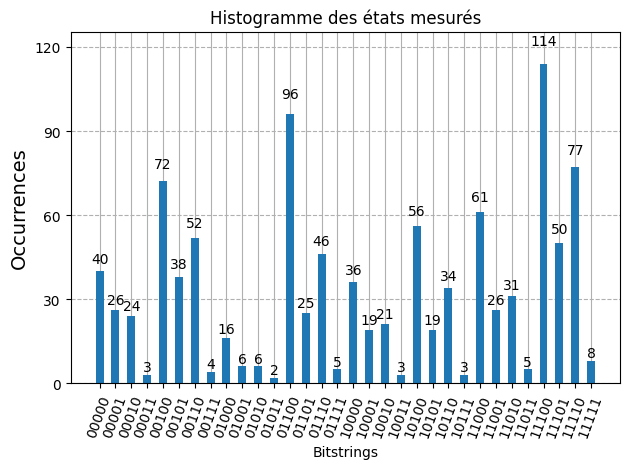

Top résultats QAOA:
11100 : 114 fois
01100 : 96 fois
11110 : 77 fois
00100 : 72 fois
11000 : 61 fois
Résultats de mesure : {'00110': 52, '00100': 72, '01101': 25, '01100': 96, '10110': 34, '10000': 36, '11100': 114, '10100': 56, '10111': 3, '00101': 38, '10001': 19, '11010': 31, '11001': 26, '11110': 77, '10101': 19, '00010': 24, '11000': 61, '11101': 50, '00000': 40, '01110': 46, '10010': 21, '11011': 5, '01010': 6, '00111': 4, '01000': 16, '00001': 26, '01001': 6, '10011': 3, '01111': 5, '11111': 8, '00011': 3, '01011': 2}
Temps d'exécution : 11.388875961303711 secondes


In [ ]:
%matplotlib inline
p=3# la profondeur


backend = Aer.get_backend('aer_simulator')

def qaoa_expectation(params):
    gammas = params[:p]
    betas = params[p:]
    
    qc = build_qaoa_circuit(nqubit, p, gammas, betas, H_c, H_M)
    qc.save_statevector()
    
    qc_transpiled = transpile(qc, backend)
    result = backend.run(qc_transpiled).result()
    
    sv = result.data(0)['statevector']
    expval = sv.expectation_value(H_c)
    return np.real(expval)  

#On initialise les valeurs de betas et gammas aléatoirement
gammas = np.linspace(0, np.pi, p) 
betas = np.linspace(0, np.pi/2, p)
params = np.concatenate([gammas, betas]) # point de départ --> initialisation



start = time.time() # on veut trouver le temps d'exécution

#result = minimize(qaoa_expectation, params, method='L-BFGS-B') #mesure
result = minimize(qaoa_expectation, params, method='COBYLA')
print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", result.fun)

# Circuit avec les paramètres optimaux --> etat pi(beta, gamma)
cost_h=H_c
mixer_h=H_M

gammas=result.x[:p]
betas=result.x[p:]

qc3 = build_qaoa_circuit(nqubit,p, gammas,betas,cost_h,mixer_h)
qc3.measure_all()
qc_transpiled3 = transpile(qc3, AerSimulator())

job = AerSimulator().run(qc_transpiled3, shots=1024)
result_new = job.result()
counts_new = result_new.get_counts()

#histogramme des probabilités
plot_histogram(counts_new)
plt.title("Histogramme des états mesurés")
plt.xlabel("Bitstrings")
plt.ylabel("Occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()


# Affichage des 5 top résultats
print("Top résultats QAOA:")
for bitstring, freq in Counter(counts_new).most_common(5):
    print(f"{bitstring} : {freq} fois")
    

print("Résultats de mesure :", counts_new)

end = time.time()
print("Temps d'exécution :", end - start, "secondes") #renvoie le temps d'exécution

p=8

Paramètres optimaux : [-1.15207538e-03  4.34309812e-01  1.89855103e+00  2.37023974e+00
  2.80153659e+00  2.23647486e+00  2.70177898e+00  3.89012720e+00
  9.90844652e-01  2.09052426e-01  4.42793953e-01  7.26091844e-01
  8.80638852e-01  1.12372678e+00  1.32612066e+00  1.57941897e+00]
Espérance d'énergie minimale : 2640.7323342079167


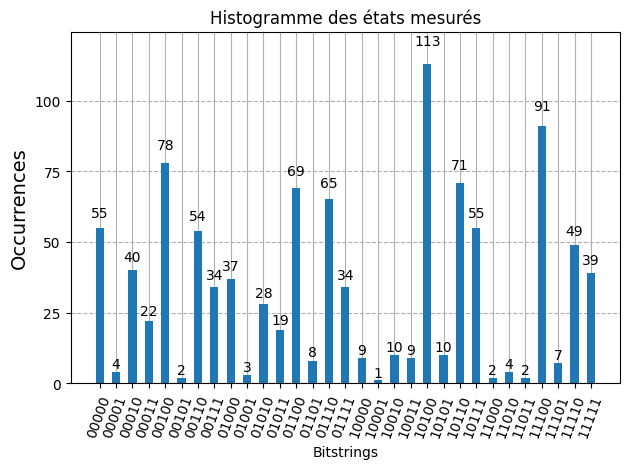

Top résultats QAOA:
10100 : 113 fois
11100 : 91 fois
00100 : 78 fois
10110 : 71 fois
01100 : 69 fois
Résultats de mesure : {'11100': 91, '01100': 69, '01000': 37, '10110': 71, '10111': 55, '00110': 54, '01111': 34, '10100': 113, '10101': 10, '00111': 34, '00011': 22, '01110': 65, '11110': 49, '00000': 55, '11101': 7, '11111': 39, '01010': 28, '00100': 78, '10010': 10, '00010': 40, '11010': 4, '00101': 2, '01011': 19, '10011': 9, '00001': 4, '10000': 9, '01101': 8, '01001': 3, '11011': 2, '10001': 1, '11000': 2}
Temps d'exécution : 21.298161506652832 secondes


In [ ]:
%matplotlib inline

p=8# la profondeur


backend = Aer.get_backend('aer_simulator')

def qaoa_expectation(params):
    gammas = params[:p]
    betas = params[p:]
    
    qc = build_qaoa_circuit(nqubit, p, gammas, betas, H_c, H_M)
    qc.save_statevector()
    
    qc_transpiled = transpile(qc, backend)
    result = backend.run(qc_transpiled).result()
    
    sv = result.data(0)['statevector']
    expval = sv.expectation_value(H_c)
    return np.real(expval)  

#On initialise les valeurs de betas et gammas aléatoirement
gammas = np.linspace(0, np.pi, p) 
betas = np.linspace(0, np.pi/2, p)
params = np.concatenate([gammas, betas]) # point de départ --> initialisation



start = time.time() # on veut trouver le temps d'exécution

#result = minimize(qaoa_expectation, params, method='L-BFGS-B') #mesure
result = minimize(qaoa_expectation, params, method='COBYLA')
print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", result.fun)

# Circuit avec les paramètres optimaux --> etat pi(beta, gamma)
cost_h=H_c
mixer_h=H_M

gammas=result.x[:p]
betas=result.x[p:]

qc3 = build_qaoa_circuit(nqubit,p, gammas,betas,cost_h,mixer_h)
qc3.measure_all()
qc_transpiled3 = transpile(qc3, AerSimulator())

job = AerSimulator().run(qc_transpiled3, shots=1024)
result_new = job.result()
counts_new = result_new.get_counts()

#histogramme des probabilités
plot_histogram(counts_new)
plt.title("Histogramme des états mesurés")
plt.xlabel("Bitstrings")
plt.ylabel("Occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()


# Affichage des 5 top résultats
print("Top résultats QAOA:")
for bitstring, freq in Counter(counts_new).most_common(5):
    print(f"{bitstring} : {freq} fois")
    

print("Résultats de mesure :", counts_new)

end = time.time()
print("Temps d'exécution :", end - start, "secondes") #renvoie le temps d'exécution